# Imports

In [1]:
import numpy as np
import data_preprocessing as dp
import plotting as p
import modeling as m

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

2025-06-25 14:45:47.794171: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Constants

In [2]:
# Switzerland
SWISS_FIRST_LOCATION_RUN = False

swiss_shape_path = "data/Switzerland/switzerland_rect.shx"

swiss_s2_rasters = ["data/Switzerland/S2_switzerland_T32TMT_20240619.tif"]
swiss_s2_merged_path = "data/Switzerland/S2_switzerland_T32TMT_20240619.tif"
swiss_s2_path = 'data/Switzerland/S2_merged_20240619_reproj.tif'

swiss_s1_2024_no_process_path = "data/Switzerland/20240103_20240701.geo.unw.tif"
swiss_s1_2024_path = 'data/Switzerland/20240103_20240701_reproj.geo.unw.tif'
swiss_s1_2023_no_process_path = "data/Switzerland/20230808_20230820.geo.unw.tif"
swiss_s1_2023_path = 'data/Switzerland/20230808_20230820_reproj.geo.unw.tif'

swiss_capella_no_process_path = "data/Switzerland/CAPELLA_C10_SS_GEO_HH_20240515031350_20240515031406.tif"
swiss_capella_path = "data/Switzerland/Capella_20240515_20240515_reproj.tif"

EXPERIMENT_RUN = 'all'  # 's2', 'iceye', 'all', 'terrasar'
NUM_SIMULATIONS = 4

# Data preprocessing

#### Set up

In [3]:
swiss_aoi = dp.get_aoi_geometry(swiss_shape_path, SWISS_FIRST_LOCATION_RUN, 'data/Switzerland/')
swiss_aoi = swiss_aoi.set_crs("EPSG:4326", allow_override=True)

if SWISS_FIRST_LOCATION_RUN:
    dp.get_sentinel2(swiss_aoi, swiss_s2_path, swiss_s2_merged_path, ((0, 0), (0, 1), (0, 0)),
                      temp_file=swiss_s2_merged_path, list_files=swiss_s2_rasters
                      )
    dp.get_interferogram(swiss_aoi, swiss_s1_2023_path, ((0, 0), (0, 1), (0, 1)), 
                         swiss_s1_2023_no_process_path
                         )
    dp.get_interferogram(swiss_aoi, swiss_s1_2024_path, ((0, 0), (0, 0), (0, 0)), 
                         swiss_s1_2024_no_process_path
                         )
    dp.get_capella(swiss_aoi, swiss_capella_path, ((0, 0), (0, 1)), swiss_capella_no_process_path)
    dp.get_ref_data(swiss_aoi, 'data/Switzerland/ref_data_abg_woody.tif', ((1, 0), (0, 0)),
                     'data/Switzerland/50N_000E.tif'
                    )

#### Optical - Sentinel 2

In [4]:
swiss_s2_data,_ = dp.get_sentinel2(aoi=swiss_aoi, file_path=swiss_s2_path, 
                                                   padding=((0, 0), (0, 1), (0, 0)), plot=False
                                                   )

#### InSAR - Interferogram

In [5]:
swiss_s1_2023_data,_ = dp.get_interferogram(aoi=swiss_aoi, file_path=swiss_s1_2023_path, 
                                                                 padding=((0, 0), (0, 1), (0, 1)), plot=False
                                                                 )
swiss_s1_2024_data,_ = dp.get_interferogram(aoi=swiss_aoi, file_path=swiss_s1_2024_path,
                                                                 padding=((0, 0), (0, 0), (0, 0)), plot=False
                                                                 )

#### Stacking

In [12]:
if EXPERIMENT_RUN == 'optical':
    swiss_combined = swiss_s2_data
elif EXPERIMENT_RUN == 'terra':
    swiss_combined = np.concatenate((swiss_s1_2023_data, swiss_s1_2024_data), axis=0)
elif EXPERIMENT_RUN == 'all':
    swiss_combined = np.concatenate((swiss_s2_data, swiss_s1_2023_data, swiss_s1_2024_data), axis=0)

#### Reference data

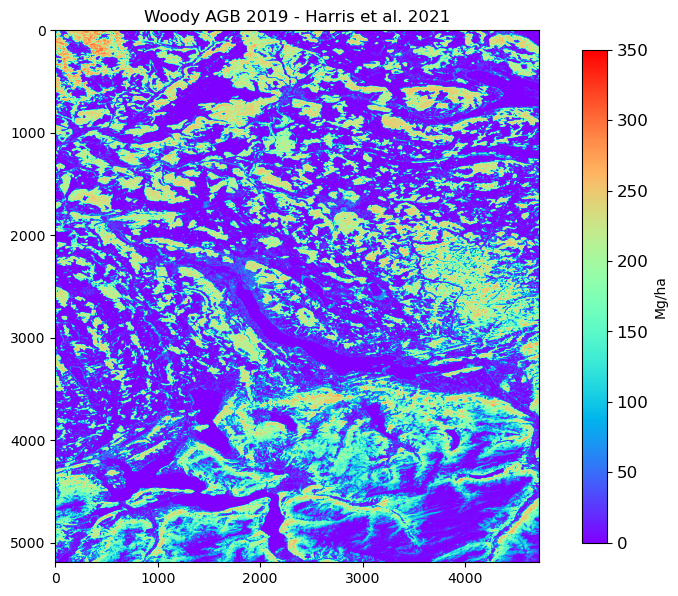

In [13]:
swiss_ref_data,_ = dp.get_ref_data(aoi=swiss_aoi, 
                                                    file_path='data/Switzerland/ref_data_abg_woody.tif', 
                                                    padding=((1, 0), (0, 0)), plot=True
                                                    )

In [14]:
del swiss_s2_data, swiss_s1_2023_data, swiss_s1_2024_data, swiss_shape_path, swiss_s2_rasters, \
    swiss_s2_merged_path, swiss_s2_path, swiss_s1_2024_no_process_path, swiss_s1_2024_path, \
    swiss_s1_2023_no_process_path, swiss_s1_2023_path,swiss_capella_no_process_path, \
    swiss_capella_path

#### Formatting for models

In [15]:
swiss_n_bands, swiss_height, swiss_width = swiss_combined.shape
n_pixels = swiss_height * swiss_width

# Make bands last and decrease dimensions
swiss_X_2d = np.transpose(swiss_combined, (1, 2, 0)).reshape(n_pixels, swiss_n_bands)       # (w*h, 14)
swiss_y_1d = swiss_ref_data.reshape(n_pixels)             # (w*h, )

# Fill in holes in the dataset
imputer = SimpleImputer(strategy='mean')
swiss_X_2d = imputer.fit_transform(swiss_X_2d)

# Split into test and train data
swiss_X_train, swiss_X_test, swiss_y_train, swiss_y_test = train_test_split(
                                                            swiss_X_2d, 
                                                            swiss_y_1d,
                                                            test_size=0.3, 
                                                            random_state=42
                                                        )

In [16]:
del swiss_combined, swiss_ref_data, swiss_n_bands, n_pixels, swiss_y_1d

# Experiments

### MLR

Training Time: 51.61 seconds
RMSE: 83.98735480302744 Mg/ha
R² Score: 0.2616413024657518


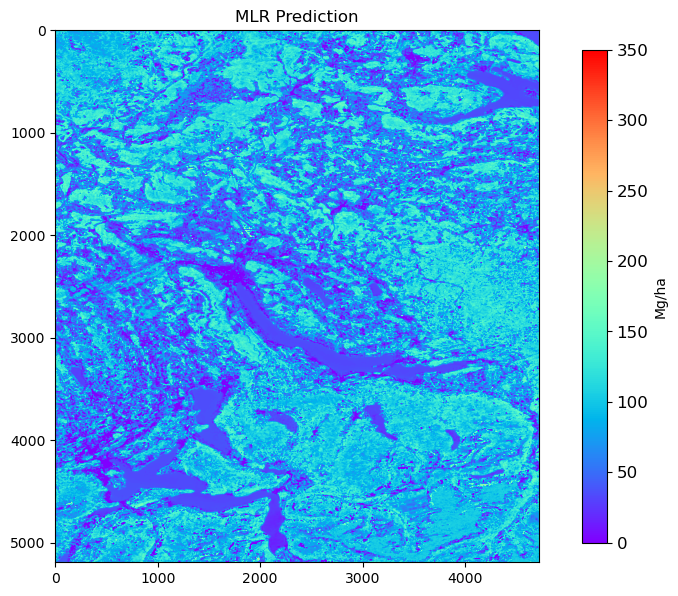

In [ ]:
# No need t run experiments in this bc mathematically deterministic
_, mlr_runtime, mlr_rmse, mlr_r2 = m.mlr(swiss_X_train, swiss_y_train, swiss_X_test, swiss_y_test, 
                                         swiss_X_2d, swiss_height, swiss_width, output=False)

if SWISS_FIRST_LOCATION_RUN:
    with open('data/output/swiss.txt', 'a') as file:
        file.write('MLR control:\n')
        file.write(str({'mlr': [mlr_runtime, mlr_rmse, mlr_r2]}))
        file.write('\n\n')

### RF

##### Parameter experiments

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   36.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   42.0s finished


Training Time: 1091.27 seconds
RMSE: 53.65336317815099 Mg/ha
R² Score: 0.6986761630659182


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.0min finished


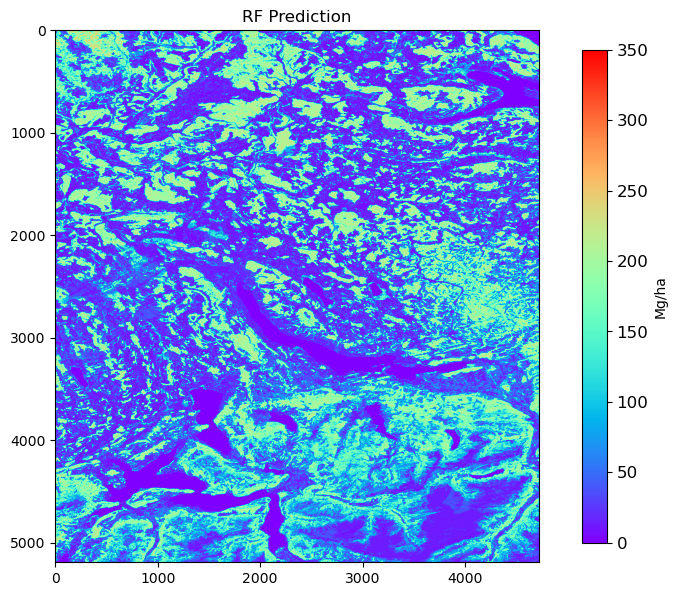

(array([4.64995000e+01, 1.12618469e+01, 7.20590553e+01, ...,
        2.05798731e+02, 4.22638972e-03, 1.48180558e+01]),
 1091.2653048038483,
 53.65336317815099,
 0.6986761630659182)

In [ ]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

if EXPERIMENT_RUN == 'all':
    rf_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'rf', swiss_X_train, swiss_y_train, 
                                        swiss_X_test, swiss_y_test, swiss_X_2d, swiss_height, swiss_width)

    with open('data/output/swiss.txt', 'a') as file:
        file.write('RF Parameter Experiments Output:\n')
        file.write(str(rf_output))
        file.write('\n\n')
    
    del rf_output

##### Input data experiments

In [ ]:
if EXPERIMENT_RUN != 'all':
    input_experiment_output_rf = m.parameter_experiments([50], [15], NUM_SIMULATIONS, 'rf', swiss_X_train, swiss_y_train, 
                                        swiss_X_test, swiss_y_test, swiss_X_2d, swiss_height, swiss_width)
    
    with open('data/output/swiss.txt', 'a') as file:
        file.write('RF Input Data Experiments Output (%s):\n' % EXPERIMENT_RUN)
        file.write(str(input_experiment_output_rf))
        file.write('\n\n')
    
    del input_experiment_output_rf

### GBT

##### Parameter experiments

In [ ]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

if EXPERIMENT_RUN == 'all':
    gbt_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'gbt', swiss_X_train, swiss_y_train, 
                                        swiss_X_test, swiss_y_test, swiss_X_2d, swiss_height, swiss_width)

    with open('data/output/swiss.txt', 'a') as file:
        file.write('GBT Parameter Experiments Output:\n')
        file.write(str(gbt_output))
        file.write('\n\n')
    
    del gbt_output

##### Input data experiments

Training Time: 349.27 seconds
RMSE: 48.41720199584961 Mg/ha
R² Score: 0.7546203136444092


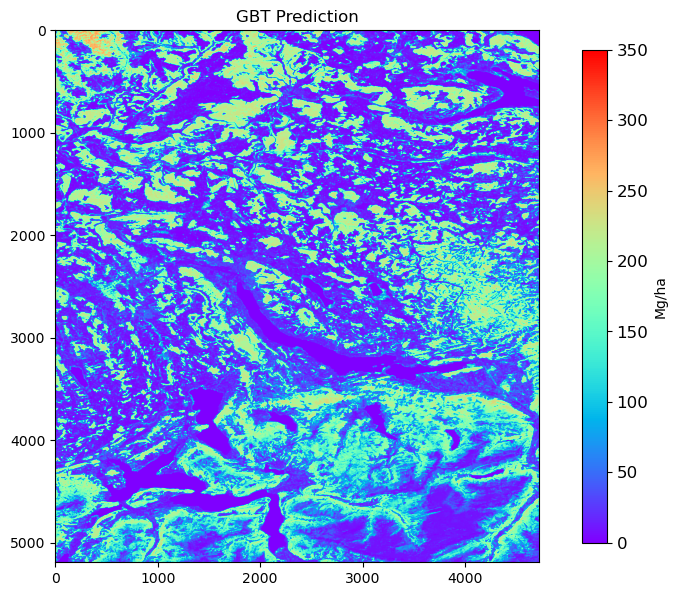

(array([ 1.3555426e+02,  1.5188233e+00,  5.0293404e+01, ...,
         2.1413689e+02, -7.9978131e-02,  1.5457952e+01], dtype=float32),
 349.2719659805298,
 48.417202,
 0.7546203136444092)

In [ ]:
if EXPERIMENT_RUN != 'all':
    input_experiment_output_gbt = m.parameter_experiments([50], [15], NUM_SIMULATIONS, 'gbt', swiss_X_train, swiss_y_train, 
                                        swiss_X_test, swiss_y_test, swiss_X_2d, swiss_height, swiss_width)
    
    with open('data/output/swiss.txt', 'a') as file:
        file.write('GBT Input Data Experiments Output (%s):\n' % EXPERIMENT_RUN)
        file.write(str(input_experiment_output_gbt))
        file.write('\n\n')